# Simulated True Colour from eReefs optical model variables

The recent (BGC3p1 and later) eReefs Biogeochemistry and Sediments model results include variables that model the optical properties of the water column.   These are intended to simulate the [Remote Sensing Reflectance](https://vocab.nerc.ac.uk/collection/P01/current/RRSWMP01/) values seen by the Ocean and Land Colour (OLCI) instruments on the Sentinel-3A and Sentinel-3B Satellites, and are used by the eReefs team to validate the model.  

eReefs also includes [True Colour datasets from the same remote sensing instruments](https://portal.ereefs.info/map?time=2022-11-30T10:00:00Z&bbox=87.1875,-43.54855,212.82715,11.7383&basemap=streetmap&dbl_layer=url=https://data.ereefs.info/dataset/item?uri=https%3A%2F%2Fwww.cmar.csiro.au%2Fgeoserver%2Frest%2Fworkspaces%2Fereefs%2Fcoveragestores%2FSentinel-3A-OLCI-GBR-RGBA_geotiffs_fs%2Fcoverages%2FSentinel-3A-OLCI-GBR.json%23Sentinel-3A-OLCI-GBR;id=https%3A%2F%2Fwww.cmar.csiro.au%2Fgeoserver%2Frest%2Fworkspaces%2Fereefs%2Fcoveragestores%2FSentinel-3A-OLCI-GBR-RGBA_geotiffs_fs%2Fcoverages%2FSentinel-3A-OLCI-GBR.json%23Sentinel-3A-OLCI-GBR;label=Sentinel-3A%20OLCI%20True%20Colour%20Composites;colorscalerange=undefined;styles=&dbl_layer=url=https://data.ereefs.info/dataset/item?uri=https%3A%2F%2Fwww.cmar.csiro.au%2Fgeoserver%2Frest%2Fworkspaces%2Fereefs%2Fcoveragestores%2FSentinel-3B-OLCI-GBR-RGBA_geotiffs_fs%2Fcoverages%2FSentinel-3B-OLCI-GBR.json%23Sentinel-3B-OLCI-GBR;id=https%3A%2F%2Fwww.cmar.csiro.au%2Fgeoserver%2Frest%2Fworkspaces%2Fereefs%2Fcoveragestores%2FSentinel-3B-OLCI-GBR-RGBA_geotiffs_fs%2Fcoverages%2FSentinel-3B-OLCI-GBR.json%23Sentinel-3B-OLCI-GBR;label=Sentinel-3B%20OLCI%20True%20Colour%20Composites;colorscalerange=undefined;styles=), which are derived from combinations of the Reflectance values.

This notebook demonstrates how to apply the same algorithm to the Remote Sensing Reflectance variables in the model results to generate a Simulated True Colour image of the whole GBR with no pesky clouds in the way.

---

For this example, we start by including a number of libraries, including the [emsarray](https://emsarray.readthedocs.io/en/stable/) library that has been developed specifically to assist with access data in eReefs-style netCDF datasets:

In [1]:
import cartopy.crs
import emsarray.plot
import numpy
import xarray
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

We now define a funtion that can combine dataset variables that best represent red (645nm wavelength), green (555nm wavelength) and blue (470nm wavelength) into a coloured image.   
This algorithm supports a couple of fudge factors to modify the brightness and saturation of the resulting image: see the comments in the code for instructions on how to apply those.

In [4]:
def reflectance_to_rgb(
    r_645: numpy.ndarray,
    r_555: numpy.ndarray,
    r_470: numpy.ndarray,
    *,
    bright_factor: float = 12.5,
    desaturate_factor: float = 0.6,
) -> numpy.ndarray:
    """
    Take an array of radiance values and transform it in to true colour.
    The colours are ramped a bit, desatureated, etc.

    Parameters
    ----------
    r_645, r_555, r_470 : numpy.ndarray
        Arrays representing the surface reflectance in wavelengths of 
        645 nm, 555 nm, and 470 nm respectively.
        The arrays must be the same shape,
        but can have any number of axes.
    bright_factor : float
        A multiplier that increases the brightness of the image.
        Higher numbers are brighter.

    Returns
    -------
    rgb: numpy.ndarray
        An array the same shape as the input arrays
        except for one extra axis of length 3.
        The final axis represents RGB values suitable for plotting.
        The values will be between 0 and 1.
    """

    # setup our rgb array using the 3 vars
    rgb = numpy.stack([r_645, r_555, r_470], axis=-1)
    rgb = numpy.nan_to_num(rgb, nan=1)

    # Some colour ramps
    in_scale = numpy.array([0,  30,  60, 120, 190, 255], dtype=numpy.float64)
    out_scale = numpy.array([0, 130, 160, 210, 240, 255], dtype=numpy.float64)

    # I'm pulling the green channel down a bit
    # as it looks more saturated than example
    g_scale = out_scale - 50
    g_scale[0] = 0
    g_scale[5] = 255

    in_scale = in_scale / 255.
    out_scale = out_scale / 255.
    g_scale = g_scale / 255.

    # apply color channel enhancement
    rgb[..., 0] = interp1d(in_scale, out_scale)(rgb[..., 0])
    rgb[..., 1] = interp1d(in_scale, g_scale)(rgb[..., 1])
    rgb[..., 2] = interp1d(in_scale, out_scale)(rgb[..., 2])

    # turn brightness back up a bit
    brighter = rgb * bright_factor

    # Desaturate the image a bit by blending with a greyscale copy.
    # The particulars here are how Pillows ImageEnhance.Color class operates.
    #
    # Convert to greyscale using the ITU-R 601-2 luma transform.
    greyscale_value = (
        brighter[..., 0] * 299/1000
        + brighter[..., 1] * 587/1000
        + brighter[..., 2] * 114/1000
    )
    greyscale = numpy.stack([greyscale_value] * 3, axis=-1)

    # Blend with the original to get a desaturated image
    desaturate_factor = 0.6
    rgb = brighter * desaturate_factor + greyscale * (1 - desaturate_factor)

    # Clip the values to the [0..1] interval
    rgb = numpy.clip(rgb, 0, 1)

    # Done!
    return rgb

We now access the model results by querying the OPeNDAP endpoint for any of the eReefs Biogeochemistry and Sediments datasets, and apply our simulated true colour algotithm to it.

For this example, we are working with the [GBR4 Biogeochemistry and Sediments v3.1 near-real-time model results](https://marlin.csiro.au/geonetwork/srv/eng/catalog.search#/metadata/7bc0d1fc-d0e4-4c1a-956f-8f7cd1a6892d):

In [ ]:
# Connect to the OPeNDAP endpoint for the dataset
dataset = emsarray.open_dataset("https://dapds00.nci.org.au/thredds/dodsC/fx3/gbr4_bgc_GBR4_H2p0_B3p1_Cfur_Dnrt.ncml")

# Select the latest time step
dataset = dataset.isel(time=-1)

# Retrieve the RGB values that will make up our image
rgb_values = reflectance_to_rgb(
    dataset.ems.ravel(dataset['R_645']),
    dataset.ems.ravel(dataset['R_555']),
    dataset.ems.ravel(dataset['R_470']),
)
rgb_values = rgb_values[dataset.ems.mask]

All that's left now is to render the image!  We will do so by using [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [Matplotlib](https://matplotlib.org/) to plot the RGB data values on a map with gridlines:

Possible issue encountered when converting Shape #1541 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #1541 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.


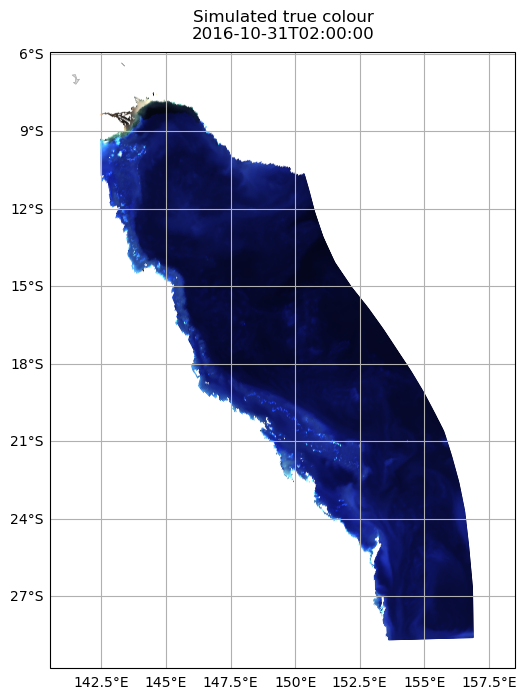

In [3]:
fig = plt.figure(figsize=(6, 8))
axes = fig.add_subplot(projection=cartopy.crs.PlateCarree())
axes.set_aspect(aspect='equal', adjustable='datalim')

plt.title(f"Simulated true colour\n{numpy.datetime_as_string(dataset['time'].values, 's')}")
axes.add_collection(dataset.ems.make_poly_collection(color=rgb_values))
emsarray.plot.add_coast(axes)
axes.gridlines(draw_labels=['left', 'bottom'])
axes.autoscale()

plt.show()